In [ ]:
# https://youtu.be/XyX5HNuv-xE
"""
Author: Dr. Sreenivas Bhattiprolu
Multiclass semantic segmentation using U-Net
Including segmenting large images by dividing them into smaller patches 
and stiching them back
To annotate images and generate labels, you can use APEER (for free):
www.apeer.com 
"""


'\nAuthor: Dr. Sreenivas Bhattiprolu\nMulticlass semantic segmentation using U-Net\nIncluding segmenting large images by dividing them into smaller patches \nand stiching them back\nTo annotate images and generate labels, you can use APEER (for free):\nwww.apeer.com \n'

In [ ]:
#imports and dependencies
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [ ]:
#let's set up the structure of our model:
def multi_unet_model(n_classes=3, IMG_HEIGHT=224, IMG_WIDTH=224, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    #s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    print(c4.shape)
    c4 = Dropout(0.2)(c4)
    print(c4.shape)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    print(c4.shape)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model#, c9 to get features 


In [ ]:
#mount drive and set up directories

from google.colab import drive

drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
#Resizing images, if needed
SIZE_X = 448 
SIZE_Y = 448
n_classes=3 #Number of classes for segmentation


In [ ]:
#Capture training image info as a list


#original images must be in same order as masks in folder
train_images = []
imgPath ="/content/drive/MyDrive/Coral_Reef_Metadata/Annotated_Arrays/"
                                #path to training imgs
for directory_path in os.listdir(imgPath):
    print(directory_path)
    arr = np.load(imgPath+directory_path)
    orig = arr["image"]     
    img = cv2.resize(orig, (SIZE_Y, SIZE_X))
    train_images.append(img)

#Convert list to array for machine learning processing        
train_images = np.array(train_images)
print(train_images.shape)

_edgesA_BS_Mira-por-vos_Islets_NIR_GD.npz
_edgesA_BZ_Glovers Reef_NIR_gd.npz
_edgesA_BZ_Lighthouse_Reef_NIR_gd.npz
_edgesA_MX_Chinchorro_Bank_NIR_GD.npz
_edgesI_GB_Saloman_NIR_GD.npz
_edgesP_PF_Aratika_Atoll_NIR_DH.npz
_edgesI_MV_Maldives_Group_16_NIR_GD.npz
_edgesP_PF_Arutua_Atoll_NIR_DH.npz
_edgesI_MV_Maldives_Group_7_NIR_GD.npz
_edgesI_MV_Maldives_Group_18_NIR_GD.npz
_edgesP_PF_Faaite_Atoll_NIR_DH.npz
_edgesI_IN_Kadmat_Island_NIR_Enter-user-ID.npz
_edgesI_IN_Agatti_Atoll_NIR_Enter-user-ID.npz
_edgesI_IN_Kitlan_Island_NIR_Enter-user-ID.npz
_edgesI_MU_Mapare_Islet_NIR_Enter-user-ID.npz
_edgesI_MU_Ile_Raphael_NIR_Enter-user-ID.npz
_edgesP_PF_Fakahina_Atoll_NIR_DH.npz
_edgesP_PF_Fakarava_Atoll_NIR_DH.npz
_edgesP_PF_Fangatau_Atoll_NIR_DH.npz
_edgesP_PF_Fangataufa_Atoll_NIR_DH.npz
_edgesP_PF_Hao_Atoll_NIR_DH.npz
_edgesP_PF_Haraiki_Atoll_NIR_DH.npz
_edgesP_PF_Hikueru_Atoll_NIR_Enter-user-ID.npz
_edgesP_PF_Hiti_Atoll_NIR_Enter-user-ID.npz
_edgesP_PF_Huahine_Island_NIR_Enter-user-ID.npz
_edg

In [ ]:

#Capture mask/label info as a list
train_masks = [] 
                                #path to respective masks
for directory_path in os.listdir(imgPath):
    print(directory_path)
    arr = np.load(imgPath+directory_path)
    orig = arr["label"]     
    img = cv2.resize(orig, (SIZE_Y, SIZE_X))
    train_masks.append(img)


#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)
print(str(train_masks.shape)+"\n"+str(train_masks.size))

_edgesA_BS_Mira-por-vos_Islets_NIR_GD.npz
_edgesA_BZ_Glovers Reef_NIR_gd.npz
_edgesA_BZ_Lighthouse_Reef_NIR_gd.npz
_edgesA_MX_Chinchorro_Bank_NIR_GD.npz
_edgesI_GB_Saloman_NIR_GD.npz
_edgesP_PF_Aratika_Atoll_NIR_DH.npz
_edgesI_MV_Maldives_Group_16_NIR_GD.npz
_edgesP_PF_Arutua_Atoll_NIR_DH.npz
_edgesI_MV_Maldives_Group_7_NIR_GD.npz
_edgesI_MV_Maldives_Group_18_NIR_GD.npz
_edgesP_PF_Faaite_Atoll_NIR_DH.npz
_edgesI_IN_Kadmat_Island_NIR_Enter-user-ID.npz
_edgesI_IN_Agatti_Atoll_NIR_Enter-user-ID.npz
_edgesI_IN_Kitlan_Island_NIR_Enter-user-ID.npz
_edgesI_MU_Mapare_Islet_NIR_Enter-user-ID.npz
_edgesI_MU_Ile_Raphael_NIR_Enter-user-ID.npz
_edgesP_PF_Fakahina_Atoll_NIR_DH.npz
_edgesP_PF_Fakarava_Atoll_NIR_DH.npz
_edgesP_PF_Fangatau_Atoll_NIR_DH.npz
_edgesP_PF_Fangataufa_Atoll_NIR_DH.npz
_edgesP_PF_Hao_Atoll_NIR_DH.npz
_edgesP_PF_Haraiki_Atoll_NIR_DH.npz
_edgesP_PF_Hikueru_Atoll_NIR_Enter-user-ID.npz
_edgesP_PF_Hiti_Atoll_NIR_Enter-user-ID.npz
_edgesP_PF_Huahine_Island_NIR_Enter-user-ID.npz
_edg

In [ ]:
# ###############################################
# #Encode labels... but multi dim array so need to flatten, encode and reshape
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# n, h, w = train_masks.shape
# train_masks_reshaped = train_masks.reshape(-1,1)
# train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
# train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

# np.unique(train_masks_encoded_original_shape)

# #################################################

In [ ]:
# train_images = np.expand_dims(train_images, axis=3)
# train_images = normalize(train_images, axis=1)

# train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split

#here need to split data and order in a way that makes index in array correspond to particular image-mask pair
#DATA MATCHING BUG CAUSED HERE!
X1, X_test, y1, y_test = train_test_split(train_images, train_masks, test_size = 0.10, random_state = 0)

#Further split training data t0 a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
# train_masks_cat = to_categorical(y_train, num_classes=n_classes)
# y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



# test_masks_cat = to_categorical(y_test, num_classes=n_classes)
# y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



Class values in the dataset are ...  [0 1]


In [ ]:
###############################################################
from sklearn.utils import class_weight
print(np.unique(train_masks))
# class_weights = class_weight.compute_class_weight(class_weight = "balanced",
#                                         classes = (0,1,2),
#                                         y = train_masks   )
# print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train, 
                    batch_size = 4, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    #class_weight=class_weights,
                    shuffle=False)
                    


model.save('test.hdf5')
#model.save('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')
############################################################

[0 1]
(None, 56, 56, 128)
(None, 56, 56, 128)
(None, 56, 56, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 448, 448, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                            

In [ ]:
#Evaluate the model
	# evaluate model
_, acc = model.evaluate(X_test, y_test)
print("Accuracy is = ", (acc * 100.0), "%")




1/1 [==============================] - 1s 1s/step - loss: 0.1489 - accuracy: 0.9405
Accuracy is =  94.0532922744751 %


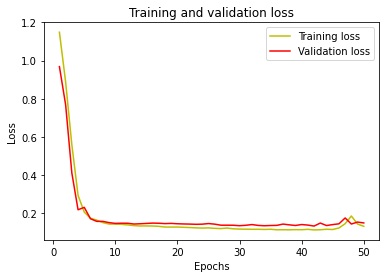

{'loss': [1.1486352682113647, 0.8874189257621765, 0.5587093234062195, 0.2935468256473541, 0.2058178186416626, 0.17360331118106842, 0.1637052446603775, 0.15062856674194336, 0.14305619895458221, 0.14255253970623016, 0.1415199339389801, 0.13856837153434753, 0.13484421372413635, 0.13303807377815247, 0.13318268954753876, 0.13280855119228363, 0.1310608983039856, 0.12741343677043915, 0.12717168033123016, 0.12738214433193207, 0.12610800564289093, 0.1246827021241188, 0.12301302701234818, 0.12198611348867416, 0.12296998500823975, 0.12044551968574524, 0.11931082606315613, 0.12196830660104752, 0.11802209168672562, 0.11667116731405258, 0.11605719476938248, 0.11544206738471985, 0.11553313583135605, 0.11479071527719498, 0.11570002883672714, 0.11298135668039322, 0.11324674636125565, 0.11295903474092484, 0.1137775406241417, 0.11347037553787231, 0.11535351723432541, 0.11230355501174927, 0.11323532462120056, 0.11568356305360794, 0.1145109310746193, 0.12248417735099792, 0.1448441743850708, 0.1853466778993

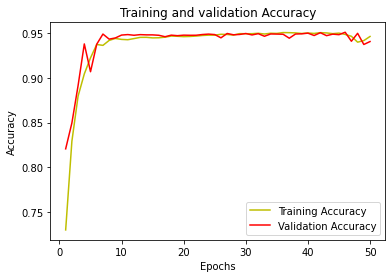

In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


##################################

In [ ]:
##################################
#model = get_model()
model.load_weights('test.hdf5')  
#model.load_weights('sandstone_50_epochs_catXentropy_acc_with_weights.hdf5')  

#IoU

y_pred=model.predict(X_test)
print(y_pred.shape)
y_pred_argmax=np.argmax(y_pred, axis=3)
print(y_pred_argmax.shape)

##################################################


1/1 [==============================] - 0s 260ms/step
(7, 448, 448, 3)
(7, 448, 448)


In [ ]:
##################################################
#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 3
testIndex = 3
IOU_keras = MeanIoU(num_classes=n_classes)  
# print(y_test[:,:,:,0].shape)
# print(y_pred_argmax[0,:,:].shape)
# print(np.around(y_pred[:,:,:,0],decimals=0).shape)
iou1 = IOU_keras.update_state(y_test[:,:,:,0], np.around(y_pred[:,:,:,0],decimals=0))
print("vegetation IoU: " + str(IOU_keras.result().numpy()))
res1 = IOU_keras.result().numpy()

iou2 = IOU_keras.update_state(y_test[:,:,:,1], np.around(y_pred[:,:,:,1],decimals=0))
print("reef flat IoU: " + str(IOU_keras.result().numpy()))
res2 = IOU_keras.result().numpy()

iou3 = IOU_keras.update_state(y_test[:,:,:,2], np.around(y_pred[:,:,:,2],decimals=0))
print("ocean IoU: " + str(IOU_keras.result().numpy()))
res3 = IOU_keras.result().numpy()

print("Mean IoU: " + str((res1+res2+res3)/3))
#I think that this is just the most recent result of IOU_keras.result(). Avg is the actual mean IoU?
#print("Mean IoU =", IOU_keras.result().numpy())

#######################################################################

vegetation IoU: 0.88490236
reef flat IoU: 0.8645413
ocean IoU: 0.9178306
Mean IoU: 0.889091412226359


In [ ]:
#evaluate other metric for accuracy
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

from keras import backend as K
from sklearn.metrics import confusion_matrix
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(y_test, y_pred, verbose=0)
print(f1_score, ", ", precision, " , ", recall)


0.7595105767250061 ,  0.7547084093093872  ,  0.764374315738678


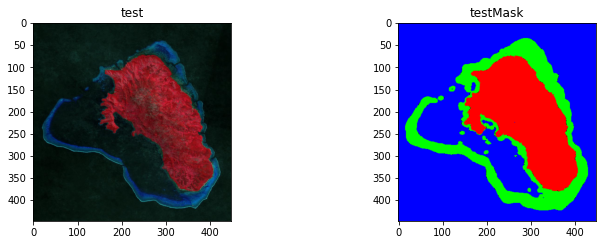

(448, 448, 3)
1/1 [==============================] - 1s 947ms/step


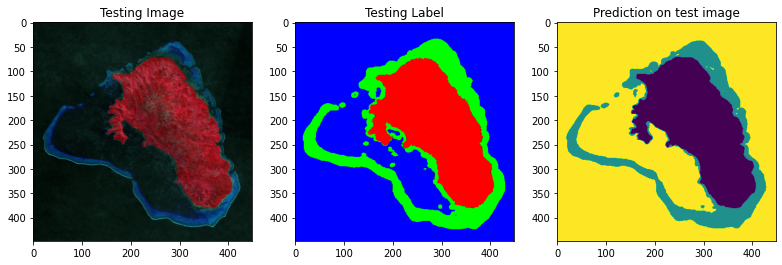

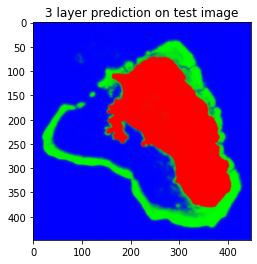

In [ ]:
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
# print(test_img.shape)
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test = np.squeeze(test_img)
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('test')
imgplot = plt.imshow(test,cmap='viridis')
plt.subplot(222)
plt.title('testMask')
imgplot = plt.imshow(255*np.squeeze(ground_truth),cmap='viridis')
plt.show()
print(test_img.shape)
four_dim = np.expand_dims(test_img, axis = 0)

prediction = (model.predict(four_dim))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(18, 20))
plt.subplot(241)
plt.title('Testing Image')
plt.imshow(test_img, cmap='viridis')
plt.subplot(242)
plt.title('Testing Label')
plt.imshow(255*ground_truth, cmap='viridis')
plt.subplot(243)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='viridis')
plt.show()
plt.title('3 layer prediction on test image')
plt.imshow(prediction[0,:,:,:], cmap='viridis')
plt.show()
#plt.savefig("StoredPlots/224_69DS")

#####################################################################

1/1 [==============================] - 0s 19ms/step


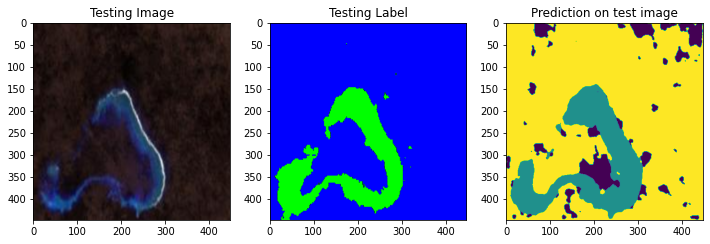

1/1 [==============================] - 0s 18ms/step


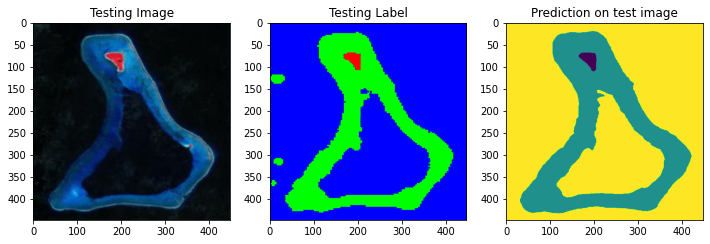

1/1 [==============================] - 0s 26ms/step


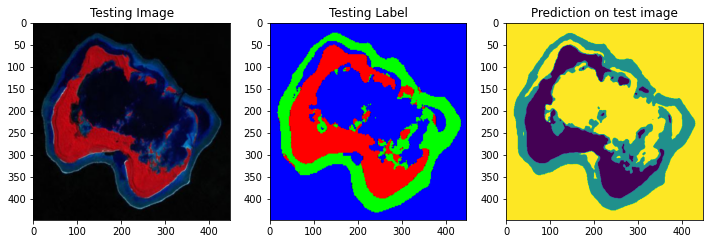

1/1 [==============================] - 0s 25ms/step


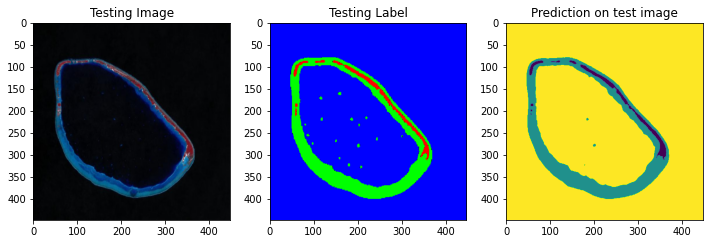

1/1 [==============================] - 0s 17ms/step


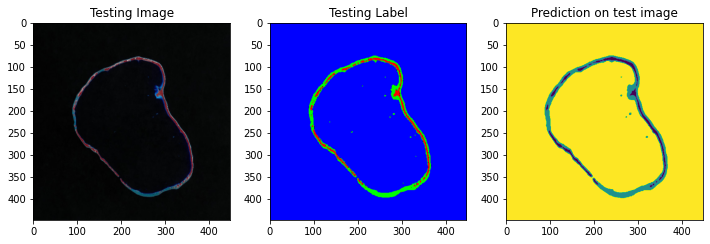

1/1 [==============================] - 0s 18ms/step


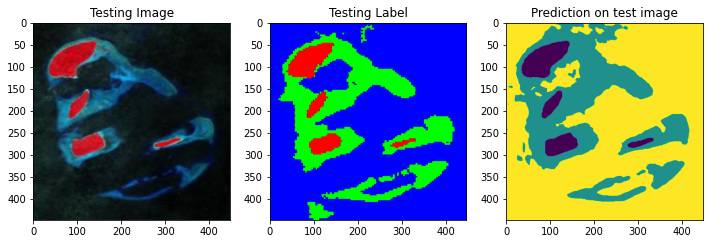

1/1 [==============================] - 0s 21ms/step


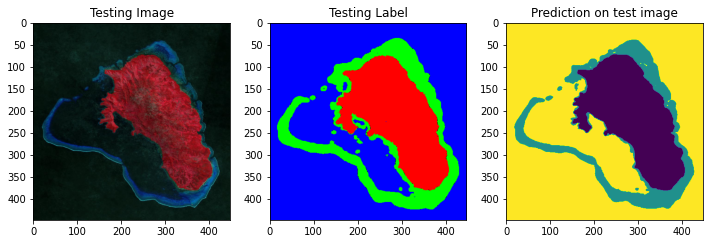

In [ ]:
for i in range(X_test.shape[0]):
  test_img = X_test[i]
  # print(test_img.shape)
  ground_truth=y_test[i]
  test_img_norm=test_img[:,:,0][:,:,None]
  four_dim = np.expand_dims(test_img, axis = 0)

  prediction = (model.predict(four_dim))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  plt.figure(figsize=(12, 8))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img, cmap='viridis')
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(255*ground_truth, cmap='viridis')
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img, cmap='viridis')
  fig = plt.gcf()
  num = random.randint(0,100)
  plt.savefig("/content/drive/MyDrive/Coral_Reef_Metadata/SavedFigs/448results"+str(num))
  plt.show()